In [1]:
'''PROGRAM LOGIC
1. Convert to numberic representation scale 1-5 for Strongly Disagree - Strongly Agree
2. Proportions Z-test for entire population (Differences in public opinion?)
    (a) Execute test after discretizing 1-5 scale to [agree, disagree]
3. Seperate Large DF into smaller DFs based on demographic questions and atrribute values
    (a) Compare answers across groups using MANN-WHITNEY & Inference Interval Comparisons
    (b) Pay attention to questions where proportions z-test showed no difference in public opinion
        (i)(e.g. number agree roughly equal to number disagree)
        (ii) Find out where the difference is coming from (E.g. Men agree, woman disagree?)
'''

'PROGRAM LOGIC\n1. Convert to numberic representation scale 1-5 for Strongly Disagree - Strongly Agree\n2. Proportions Z-test for entire population (Differences in public opinion?)\n    (a) Execute test after discretizing 1-5 scale to [agree, disagree]\n3. Seperate Large DF into smaller DFs based on demographic questions and atrribute values\n    (a) Compare answers across groups using MANN-WHITNEY & Inference Interval Comparisons\n    (b) Pay attention to questions where proportions z-test showed no difference in public opinion\n        (i)(e.g. number agree roughly equal to number disagree)\n        (ii) Find out where the difference is coming from (E.g. Men agree, woman disagree?)\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [3]:
df = pd.read_csv('general_public.csv')

In [4]:
#Self-contained cell for converting data into numerical format for strongly agree questions
str2int_dict = {'Strongly Agree':5, 'Agree':4, 'Undecided': 3,'Disagree':2, 'Strongly Disagree':1}
def str2int(st):
    if ((type(st) == str) and (st.endswith('agree') or st.endswith('Agree') or st.endswith('decided'))):
        return str2int_dict[st]
    else:
        return st

for col in df.columns:
    df[col] = df[col].apply(str2int)

In [5]:
#Self-contained cell for converting data into numerical format for frequency questions
str2int_dict2 = {'Always':5, 'Often':4, 'Sometimes': 3,'Rarely':2, 'Never':1}
def str2int(st):
    if ((type(st) == str) and (st.endswith('Always') or st.endswith('Often') or 
                               st.endswith('Sometimes') or st.endswith('Rarely') or
                               st.endswith('Never'))):
        return str2int_dict2[st]
    else:
        return st

for col in df.columns:
    df[col] = df[col].apply(str2int)

In [16]:
# Cell for hard coding the questions we want to analyze
q0 = "I would find it useful to have a filter that could change my race in videos."
q1 = "I would want a viewer to have the option to change my race in videos."
q2 = "I would find it useful to have a filter that could change my gender in videos."
q3 = "I would want a viewer to have the option to change my gender in videos."
q4 = "The speaker should have the option to remove the tremors from the video."
q_list = [q0, q1, q2, q3, q4]

In [17]:
# This is to generate a table of distributions (counts) for each answer for each question
# 'Strongly Agree':5, 'Agree':4, 'Undecided': 3,'Disagree':2, 'Strongly Disagree':1
# str2int_dict2 = {'Always':5, 'Often':4, 'Sometimes': 3,'Rarely':2, 'Never':1}
df_counts = pd.DataFrame()
for q in q_list:
    col_name = q
    df_counts[col_name] = df[col_name].value_counts() # applies function for every row in specified column
display(df_counts)

,I would find it useful to have a filter that could change my race in videos.,I would want a viewer to have the option to change my race in videos.,I would find it useful to have a filter that could change my gender in videos.,I would want a viewer to have the option to change my gender in videos.,The speaker should have the option to remove the tremors from the video.
1,35,34,27,35,3
4,30,27,28,23,44
2,25,21,30,27,12
5,9,11,11,12,30
3,9,15,12,11,19


In [18]:
# here we create a dataframe containing only disagree and agree sums
# Keep in mind there is a frequency question... close enough ?
df_agree = df_counts.loc[[4, 5],:].sum()
df_disagree = df_counts.loc[[1,2],:].sum()
df_neutral = df_counts.loc[[3],:].sum()
df_AD = pd.concat([df_agree, df_disagree], axis=1)
df_AD.columns = ['Agree','Disagree']
print("Count for those who AGREED to the questions: ")
display(df_agree)
print("Count for those who DISAGREED to the questions: ")
display(df_disagree)
display(df_AD)

Count for those who AGREED to the questions: 


I would find it useful to have a filter that could change my race in videos.      39
I would want a viewer to have the option to change my race in videos.             38
I would find it useful to have a filter that could change my gender in videos.    39
I would want a viewer to have the option to change my gender in videos.           35
The speaker should have the option to remove the tremors from the video.          74
dtype: int64

Count for those who DISAGREED to the questions: 


I would find it useful to have a filter that could change my race in videos.      60
I would want a viewer to have the option to change my race in videos.             55
I would find it useful to have a filter that could change my gender in videos.    57
I would want a viewer to have the option to change my gender in videos.           62
The speaker should have the option to remove the tremors from the video.          15
dtype: int64

,Agree,Disagree
I would find it useful to have a filter that could change my race in videos.,39,60
I would want a viewer to have the option to change my race in videos.,38,55
I would find it useful to have a filter that could change my gender in videos.,39,57
I would want a viewer to have the option to change my gender in videos.,35,62
The speaker should have the option to remove the tremors from the video.,74,15


In [9]:
# testing for population differences on all questions
# statsmodels.stats.proportion.proportions_ztest(count, nobs, value=None, 
#                   alternative='two-sided', prop_var=False)
# Returns statistic and p-value
# Null Hypothesis = There is no difference in public opinion. 
    # E.g., Number who agree is equal to the number who disagree

for q in q_list:
    print(q)
    row_ID = q
    num_agree = df_AD.loc[row_ID,'Agree']
    num_disagree = df_AD.loc[row_ID,'Disagree']
    t, p = proportions_ztest(num_agree, (num_agree+num_disagree), value=.5) # Assume no difference 
    print("T: ", t, "P: ", p)
    print("\n==========================\n")

I would find it useful to have a filter that could change my race in videos.
T:  -2.1597275469195365 P:  0.03079376737938273


I would want a viewer to have the option to change my race in videos.
T:  -1.7930287652768 P:  0.07296832466551766


I would find it useful to have a filter that could change my gender in videos.
T:  -1.870287600478072 P:  0.06144389048998359


I would want a viewer to have the option to change my gender in videos.
T:  -2.854235271692773 P:  0.004314056953702637




In [38]:
# Self contained cell Looking at only the people who supported PD filter
df_pd_agree = df[(df['The speaker should have the option to remove the tremors from the video.'] == 4) |
                (df['The speaker should have the option to remove the tremors from the video.'] == 5)].copy()

# This is to generate a table of distributions (counts) for each answer for each question
# 'Strongly Agree':5, 'Agree':4, 'Undecided': 3,'Disagree':2, 'Strongly Disagree':1
# str2int_dict2 = {'Always':5, 'Often':4, 'Sometimes': 3,'Rarely':2, 'Never':1}
df_counts = pd.DataFrame()
for q in q_list:
    col_name = q
    df_counts[col_name] = df_pd_agree[col_name].value_counts() # applies function for every row in specified column
# here we create a dataframe containing only disagree and agree sums
# Keep in mind there is a frequency question... close enough ?
display(df_counts)
print("Agree Disagree Counts for people who agreed to PD video filter:")
df_agree = df_counts.loc[[4, 5],:].sum()
df_disagree = df_counts.loc[[1,2],:].sum()
df_neutral = df_counts.loc[[3],:].sum()
df_AD = pd.concat([df_agree, df_disagree], axis=1)
df_AD.columns = ['Agree','Disagree']
print("Count for those who AGREED to the race and gender filter questions: ")
display(df_agree)
print("Count for those who DISAGREED to the race and gender filter questions: ")
display(df_disagree)
display(df_AD)

,I would find it useful to have a filter that could change my race in videos.,I would want a viewer to have the option to change my race in videos.,I would find it useful to have a filter that could change my gender in videos.,I would want a viewer to have the option to change my gender in videos.,The speaker should have the option to remove the tremors from the video.
4,27,23,24,19,44.0
1,20,20,16,22,NaN
2,14,12,16,13,NaN
5,8,11,9,12,30.0
3,5,8,9,8,NaN


Agree Disagree Counts for people who agreed to PD video filter:
Count for those who AGREED to the race and gender filter questions: 


I would find it useful to have a filter that could change my race in videos.      35.0
I would want a viewer to have the option to change my race in videos.             34.0
I would find it useful to have a filter that could change my gender in videos.    33.0
I would want a viewer to have the option to change my gender in videos.           31.0
The speaker should have the option to remove the tremors from the video.          74.0
dtype: float64

Count for those who DISAGREED to the race and gender filter questions: 


I would find it useful to have a filter that could change my race in videos.      34.0
I would want a viewer to have the option to change my race in videos.             32.0
I would find it useful to have a filter that could change my gender in videos.    32.0
I would want a viewer to have the option to change my gender in videos.           35.0
The speaker should have the option to remove the tremors from the video.           0.0
dtype: float64

,Agree,Disagree
I would find it useful to have a filter that could change my race in videos.,35.0,34.0
I would want a viewer to have the option to change my race in videos.,34.0,32.0
I would find it useful to have a filter that could change my gender in videos.,33.0,32.0
I would want a viewer to have the option to change my gender in videos.,31.0,35.0
The speaker should have the option to remove the tremors from the video.,74.0,0.0


In [37]:
# Here we only look at the people who support the race AND gender filters
df_race_gender_agree = df[((df['I would find it useful to have a filter that could change my race in videos.'] == 4) |
                (df['I would find it useful to have a filter that could change my race in videos.'] == 5)) &
                ((df['I would find it useful to have a filter that could change my gender in videos.'] == 4) |
                (df['I would find it useful to have a filter that could change my gender in videos.'] == 5))].copy()

print('Size of DF for those who supported BOTH race and gender filter')
display(len(df_race_gender_agree))
df_counts = pd.DataFrame()
#for q in q_list:
 #   col_name = q
  #  df_counts[col_name] = df_race_gender_agree[col_name].value_counts() # applies function for every row in specified column

col_name = q_list[-1]
df_counts[col_name] = df_race_gender_agree[col_name].value_counts()
display(df_counts)
df_agree = df_counts.loc[[4, 5],:].sum()
df_disagree = df_counts.loc[[2],:].sum()
df_neutral = df_counts.loc[[3],:].sum()
df_AD = pd.concat([df_agree, df_disagree], axis=1)
df_AD.columns = ['Agree','Disagree']
print("Count for those who AGREED to  ")
display(df_agree)
print("Count for those who DISAGREED to the race and gender filter questions: ")
display(df_disagree)
display(df_AD)

'length of df race gender:'

31

,The speaker should have the option to remove the tremors from the video.
4,16
5,11
3,3
2,1


Count for those who AGREED to the race and gender filter questions: 


The speaker should have the option to remove the tremors from the video.    27
dtype: int64

Count for those who DISAGREED to the race and gender filter questions: 


The speaker should have the option to remove the tremors from the video.    1
dtype: int64

,Agree,Disagree
The speaker should have the option to remove the tremors from the video.,27,1


In [10]:
# self-contained cell to determine interval for 95% of distr
# 95 % of a distribution falls between 2 standard-deviations of the mean
# params = (mu, std)
# returns list [mu-(2*std), mu, mu+(2*std)]
def compute_interval95(mu, std):
    lower_bound = mu - (2*std)
    upper_bound = mu + (2*std)
    ret_list = [lower_bound, mu, upper_bound]
    return ret_list

In [11]:
# self-contained cell for determining overlap of confidence intervals
# Used to determine DIFFERENCE of opinoin betweeen 2 groups
# params =[interval_list1, interval_list2]
# Returns TRUE if NO overlap bc no overlap means difference
def is_difference(interval_list1, interval_list2):
    lower_bound1 = interval_list1[0]
    upper_bound1 = interval_list1[-1]
    lower_bound2 = interval_list2[0]
    upper_bound2 = interval_list2[-1]
    if ((lower_bound2 >= upper_bound1) or (upper_bound2 <= lower_bound1)):
        return True # distributions do not overlap
    else:
        return False # distributinos overlap!

I would find it useful to have a filter that could change my race in videos.
Male


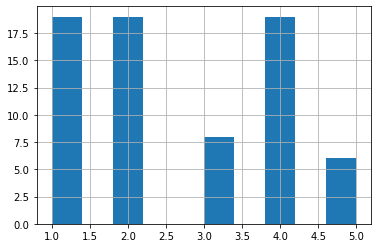

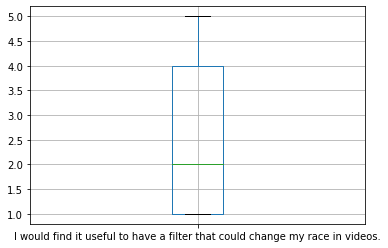

Female


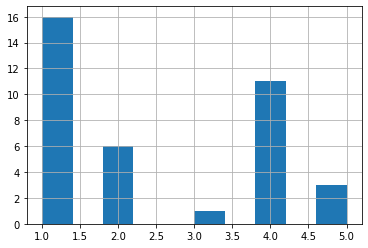

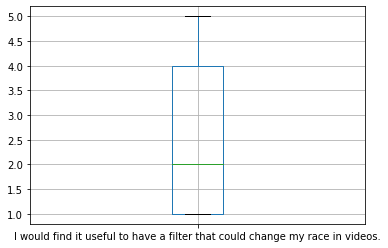

,count,mean,std,min,25%,50%,75%,max
What is your gender?,,,,,,,,
Female,37.0,2.432432,1.500751,1.0,1.0,2.0,4.0,5.0
Male,71.0,2.633803,1.354774,1.0,1.0,2.0,4.0,5.0


p-value =  0.18521775281815867
u-value=  -2.854235271692773
Male:  [-0.07574509730796786, 2.6338028169014085, 5.343350731110785]
Female:  [-0.569068693505888, 2.4324324324324325, 5.433933558370753]
There is a Difference:  False


I would want a viewer to have the option to change my race in videos.
Male


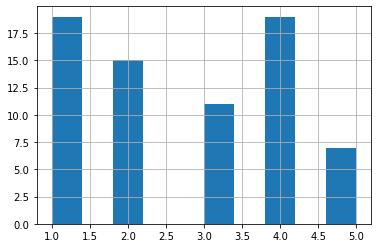

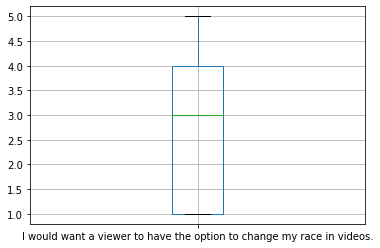

Female


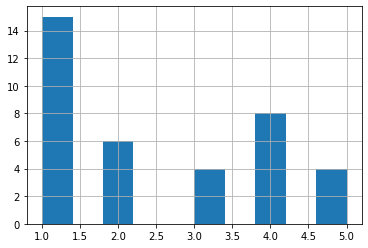

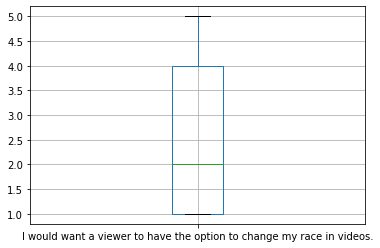

,count,mean,std,min,25%,50%,75%,max
What is your gender?,,,,,,,,
Female,37.0,2.459459,1.483138,1.0,1.0,2.0,4.0,5.0
Male,71.0,2.718310,1.375117,1.0,1.0,3.0,4.0,5.0


p-value =  0.16262449148833485
u-value=  -2.854235271692773
Male:  [-0.031923348443485544, 2.7183098591549295, 5.468543066753345]
Female:  [-0.5068174660481364, 2.4594594594594597, 5.425736384967056]
There is a Difference:  False


I would find it useful to have a filter that could change my gender in videos.
Male


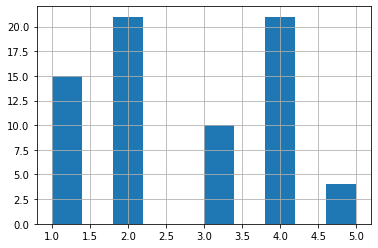

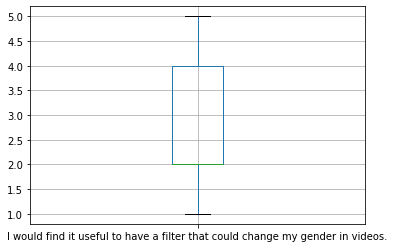

Female


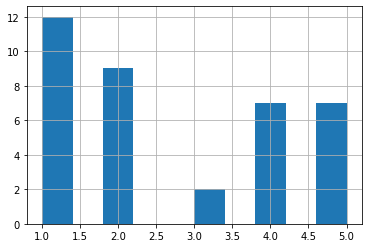

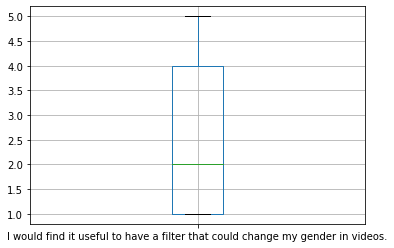

,count,mean,std,min,25%,50%,75%,max
What is your gender?,,,,,,,,
Female,37.0,2.675676,1.564432,1.0,1.0,2.0,4.0,5.0
Male,71.0,2.690141,1.260290,1.0,2.0,2.0,4.0,5.0


p-value =  0.4129466031294241
u-value=  -2.854235271692773
Male:  [0.1695615625408884, 2.6901408450704225, 5.210720127599957]
Female:  [-0.45318830183913317, 2.675675675675676, 5.804539653190485]
There is a Difference:  False


I would want a viewer to have the option to change my gender in videos.
Male


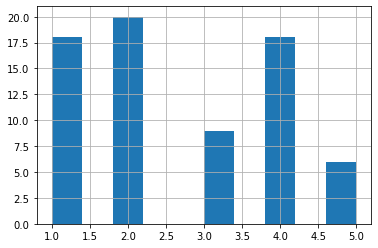

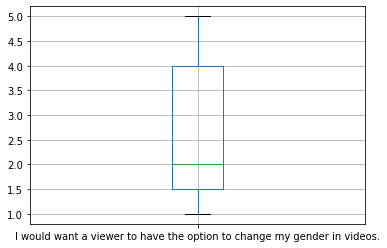

Female


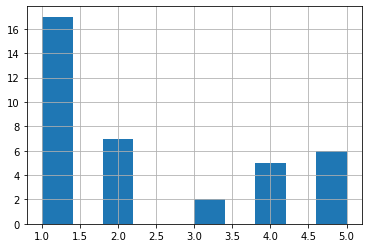

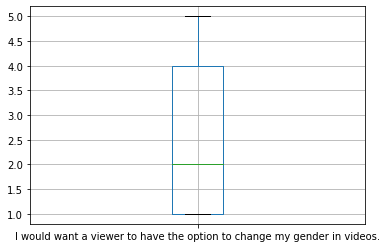

,count,mean,std,min,25%,50%,75%,max
What is your gender?,,,,,,,,
Female,37.0,2.351351,1.567309,1.0,1.0,2.0,4.0,5.0
Male,71.0,2.633803,1.333518,1.0,1.5,2.0,4.0,5.0


p-value =  0.10089907505818263
u-value=  -2.854235271692773
Male:  [-0.03323270420155433, 2.6338028169014085, 5.300838338004372]
Female:  [-0.7832659818850076, 2.3513513513513513, 5.485968684587711]
There is a Difference:  False




In [12]:
# Gender Cell
# Compute the Mann-Whitney rank test on samples x and y
# scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)

g = df.groupby('What is your gender?')

df_male = df[(df['What is your gender?'] == 'Male')].copy()
df_female = df[(df['What is your gender?'] == 'Female')].copy()

for q in q_list:
    col_name = q
    print(col_name)
    print("Male")
    df_male[col_name].hist()
    plt.show()
    df_male.boxplot(col_name)
    plt.show()
    print("Female")
    df_female[col_name].hist()
    plt.show()
    df_female.boxplot(col_name)
    plt.show()
    display(g[col_name].describe())
    #Statistic test
    u,p = mannwhitneyu(df_male[col_name], df_female[col_name])
    print('p-value = ', p)
    print('u-value= ', t)
    mu1 = df_male[col_name].mean()
    std1 = df_male[col_name].std()
    mu2 = df_female[col_name].mean()
    std2 = df_female[col_name].std()
    print("Male: ", compute_interval95(mu1, std1))
    print("Female: ", compute_interval95(mu2, std2))
    print("There is a Difference: ", is_difference(compute_interval95(mu1, std1), compute_interval95(mu2, std2)))
    print('\n========================================\n')

I would find it useful to have a filter that could change my race in videos.
Young


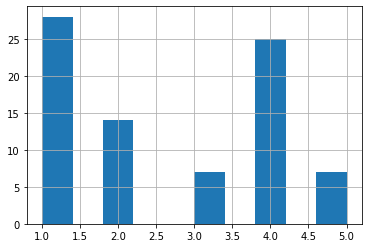

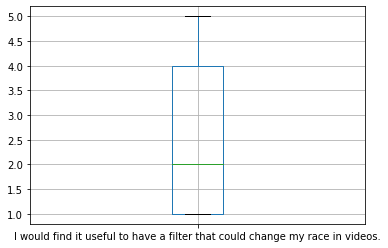

Old


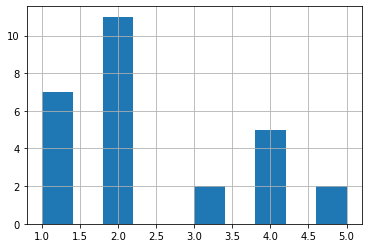

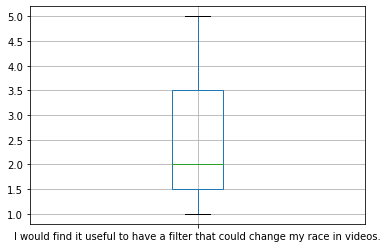

,count,mean,std,min,25%,50%,75%,max
What is your age?,,,,,,,,
18-24 years old,4.0,1.750000,1.500000,1.0,1.00,1.0,1.75,4.0
25-34 years old,55.0,2.800000,1.458056,1.0,1.00,3.0,4.00,5.0
35-44 years old,22.0,2.318182,1.358794,1.0,1.00,2.0,4.00,4.0
45-54 years old,14.0,2.642857,1.499084,1.0,1.25,2.0,4.00,5.0
55-64 years old,12.0,2.166667,1.029857,1.0,1.75,2.0,2.25,4.0
65-74 years old,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0


p-value =  0.3389075781537646
u-value=  -2.854235271692773
Young:  [-0.2735273755430363, 2.617283950617284, 5.508095276777604]
Old:  [-0.1501911813688963, 2.4074074074074074, 4.965005996183711]
There is a Difference:  False


I would want a viewer to have the option to change my race in videos.
Young


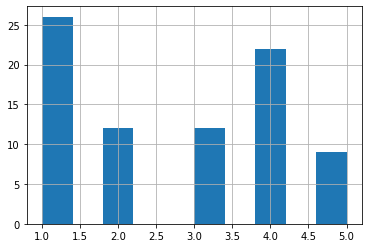

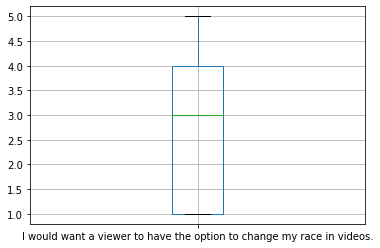

Old


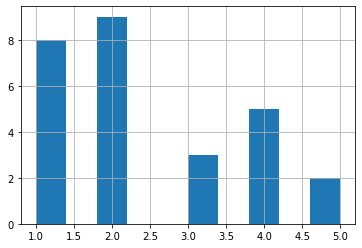

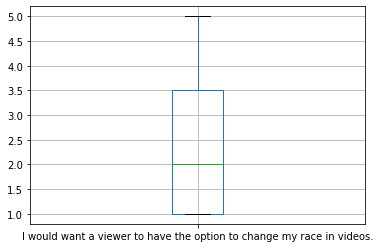

,count,mean,std,min,25%,50%,75%,max
What is your age?,,,,,,,,
18-24 years old,4.0,1.500000,1.000000,1.0,1.0,1.0,1.50,3.0
25-34 years old,55.0,2.909091,1.481650,1.0,1.0,3.0,4.00,5.0
35-44 years old,22.0,2.409091,1.296849,1.0,1.0,2.0,3.75,5.0
45-54 years old,14.0,2.785714,1.423893,1.0,2.0,2.5,4.00,5.0
55-64 years old,12.0,2.000000,1.128152,1.0,1.0,2.0,2.25,4.0
65-74 years old,1.0,2.000000,NaN,2.0,2.0,2.0,2.00,2.0


p-value =  0.20858039332577527
u-value=  -2.854235271692773
Young:  [-0.18497150206873547, 2.7037037037037037, 5.5923789094761425]
Old:  [-0.2096525554140123, 2.4074074074074074, 5.024467370228827]
There is a Difference:  False


I would find it useful to have a filter that could change my gender in videos.
Young


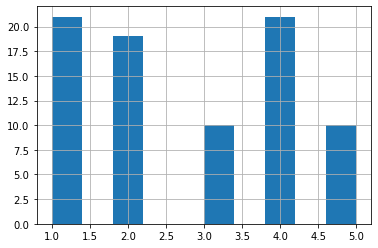

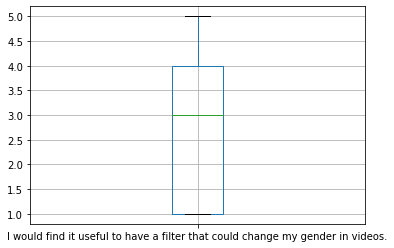

Old


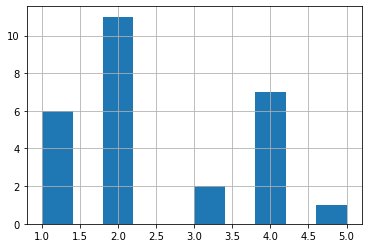

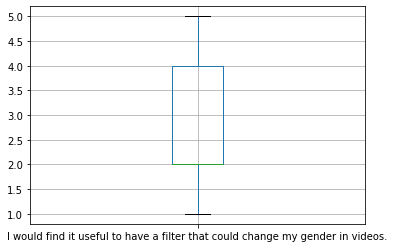

,count,mean,std,min,25%,50%,75%,max
What is your age?,,,,,,,,
18-24 years old,4.0,2.000000,2.000000,1.0,1.00,1.0,2.0,5.0
25-34 years old,55.0,2.909091,1.391412,1.0,2.00,3.0,4.0,5.0
35-44 years old,22.0,2.500000,1.336306,1.0,1.00,2.0,4.0,5.0
45-54 years old,14.0,2.785714,1.251373,1.0,2.00,3.0,4.0,4.0
55-64 years old,12.0,2.166667,1.193416,1.0,1.75,2.0,2.0,5.0
65-74 years old,1.0,2.000000,NaN,2.0,2.00,2.0,2.0,2.0


p-value =  0.2215132340624733
u-value=  -2.854235271692773
Young:  [-0.06703528325071995, 2.753086419753086, 5.573208122756892]
Old:  [0.04014701850555413, 2.4814814814814814, 4.922815944457408]
There is a Difference:  False


I would want a viewer to have the option to change my gender in videos.
Young


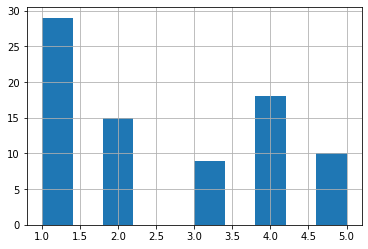

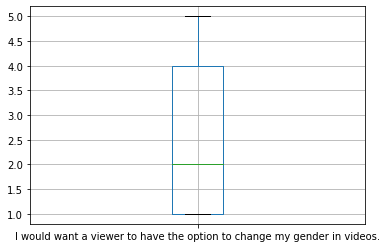

Old


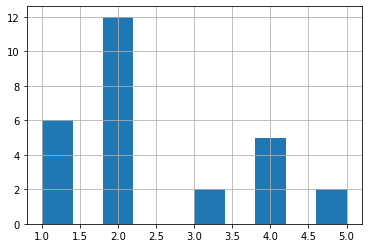

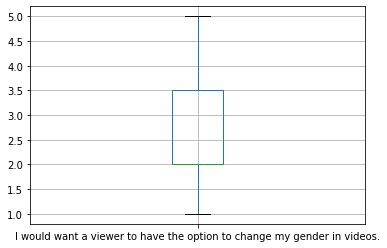

,count,mean,std,min,25%,50%,75%,max
What is your age?,,,,,,,,
18-24 years old,4.0,1.500000,1.000000,1.0,1.0,1.0,1.50,3.0
25-34 years old,55.0,2.745455,1.530168,1.0,1.0,3.0,4.00,5.0
35-44 years old,22.0,2.318182,1.323285,1.0,1.0,2.0,3.75,5.0
45-54 years old,14.0,2.857143,1.350621,1.0,2.0,2.5,4.00,5.0
55-64 years old,12.0,2.000000,1.044466,1.0,1.0,2.0,2.00,4.0
65-74 years old,1.0,2.000000,NaN,2.0,2.0,2.0,2.00,2.0


p-value =  0.47372077095087706
u-value=  -2.854235271692773
Young:  [-0.3806284262111501, 2.567901234567901, 5.516430895346952]
Old:  [-0.056837278274981085, 2.4444444444444446, 4.945726167163871]
There is a Difference:  False




In [13]:
# Age Cell
# Compute the Mann-Whitney rank test on samples x and y
# scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)

g = df.groupby('What is your age?')

df_young = df[(df['What is your age?'] == '18-24 years old') | 
             (df['What is your age?'] == '25-34 years old') |
             (df['What is your age?'] == '35-44 years old')].copy()

df_old = df[(df['What is your age?'] == '45-54 years old') | 
             (df['What is your age?'] == '55-64 years old') |
             (df['What is your age?'] == '65-74 years old') |
             (df['What is your age?'] == '75 years or older')].copy()

for q in q_list:
    col_name = q
    print(col_name)
    print("Young")
    df_young[col_name].hist()
    plt.show()
    df_young.boxplot(col_name)
    plt.show()
    print("Old")
    df_old[col_name].hist()
    plt.show()
    df_old.boxplot(col_name)
    plt.show()
    display(g[col_name].describe())
    #Statistic test
    u,p = mannwhitneyu(df_young[col_name], df_old[col_name])
    print('p-value = ', p)
    print('u-value= ', t)
    mu1 = df_young[col_name].mean()
    std1 = df_young[col_name].std()
    mu2 = df_old[col_name].mean()
    std2 = df_old[col_name].std()
    print("Young: ", compute_interval95(mu1, std1))
    print("Old: ", compute_interval95(mu2, std2))
    print("There is a Difference: ", is_difference(compute_interval95(mu1, std1), compute_interval95(mu2, std2)))
    print('\n========================================\n')

I would find it useful to have a filter that could change my race in videos.
White


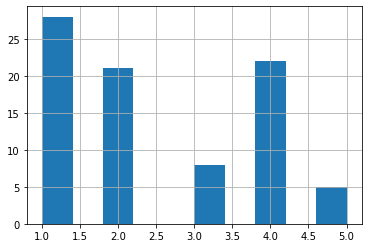

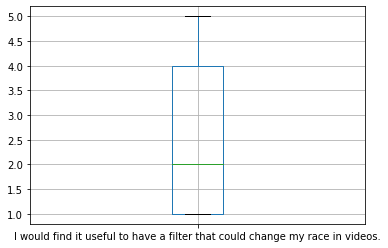

Not White


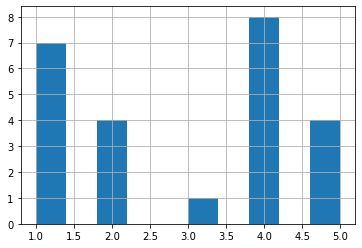

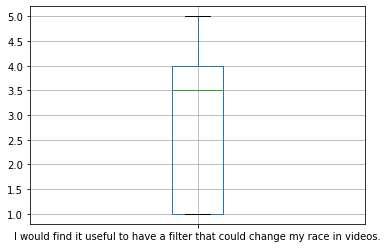

,count,mean,std,min,25%,50%,75%,max
What is your race? (Check all that apply),,,,,,,,
American Indian or Alaska Native,1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
Asian,7.0,2.714286,1.603567,1.0,1.5,2.0,4.0,5.0
Black or African American,11.0,2.818182,1.470930,1.0,1.5,3.0,4.0,5.0
White,84.0,2.464286,1.348327,1.0,1.0,2.0,4.0,5.0
"White, American Indian or Alaska Native",1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
"White, Asian",2.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
"White, Asian, Native Hawaiian or Pacific Islander",1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
"White, Black or African American, American Indian or Alaska Native, Asian, Native Hawaiian or Pacific Islander",1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0


p-value =  0.10112879076265013
u-value=  -2.854235271692773
White:  [-0.23236868006060707, 2.4642857142857144, 5.160940108632036]
Not White:  [-0.19944387815298636, 2.9166666666666665, 6.032777211486319]
There is a Difference:  False


I would want a viewer to have the option to change my race in videos.
White


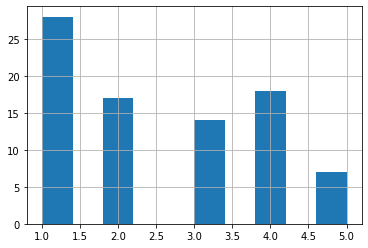

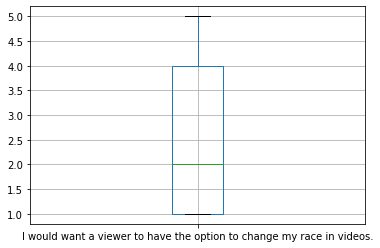

Not White


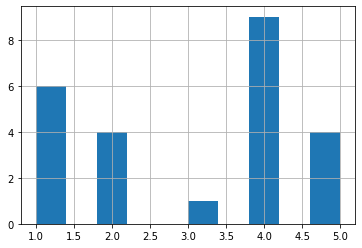

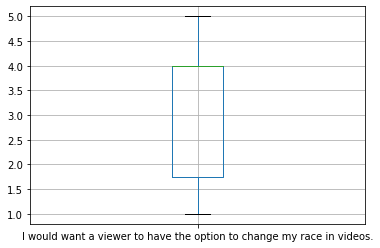

,count,mean,std,min,25%,50%,75%,max
What is your race? (Check all that apply),,,,,,,,
American Indian or Alaska Native,1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
Asian,7.0,2.714286,1.704336,1.0,1.0,3.0,4.0,5.0
Black or African American,11.0,2.818182,1.401298,1.0,2.0,2.0,4.0,5.0
White,84.0,2.511905,1.366502,1.0,1.0,2.0,4.0,5.0
"White, American Indian or Alaska Native",1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0
"White, Asian",2.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
"White, Asian, Native Hawaiian or Pacific Islander",1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
"White, Black or African American, American Indian or Alaska Native, Asian, Native Hawaiian or Pacific Islander",1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0


p-value =  0.057082990645492035
u-value=  -2.854235271692773
White:  [-0.2210983106524207, 2.511904761904762, 5.244907834461944]
Not White:  [0.00684460803847875, 3.0416666666666665, 6.076488725294855]
There is a Difference:  False


I would find it useful to have a filter that could change my gender in videos.
White


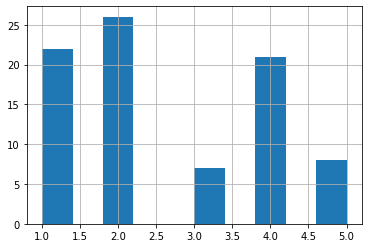

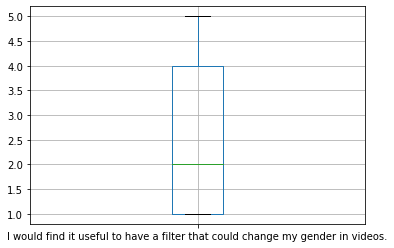

Not White


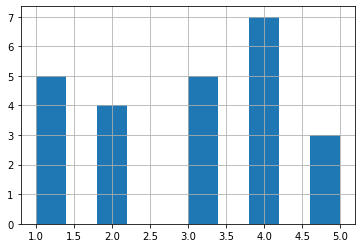

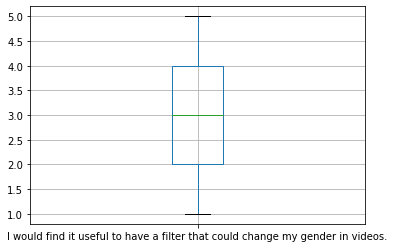

,count,mean,std,min,25%,50%,75%,max
What is your race? (Check all that apply),,,,,,,,
American Indian or Alaska Native,1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
Asian,7.0,2.571429,1.272418,1.0,1.5,3.0,3.5,4.0
Black or African American,11.0,3.000000,1.414214,1.0,2.0,4.0,4.0,5.0
White,84.0,2.607143,1.362297,1.0,1.0,2.0,4.0,5.0
"White, American Indian or Alaska Native",1.0,3.000000,NaN,3.0,3.0,3.0,3.0,3.0
"White, Asian",2.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
"White, Asian, Native Hawaiian or Pacific Islander",1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
"White, Black or African American, American Indian or Alaska Native, Asian, Native Hawaiian or Pacific Islander",1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0


p-value =  0.13911423059355188
u-value=  -2.854235271692773
White:  [-0.11745030833778314, 2.607142857142857, 5.331736022623497]
Not White:  [0.22501767414692653, 2.9583333333333335, 5.69164899251974]
There is a Difference:  False


I would want a viewer to have the option to change my gender in videos.
White


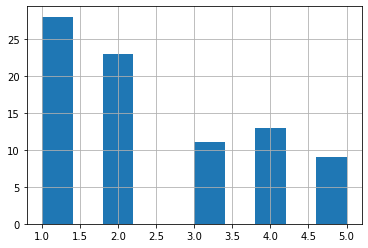

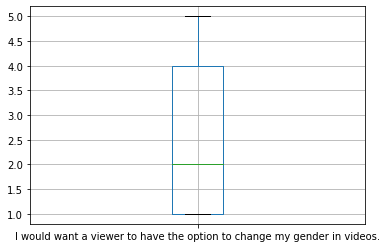

Not White


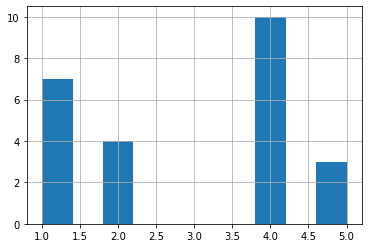

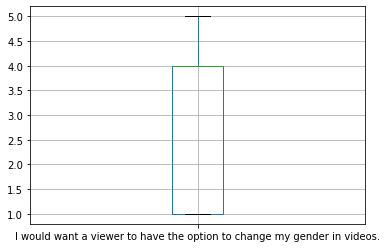

,count,mean,std,min,25%,50%,75%,max
What is your race? (Check all that apply),,,,,,,,
American Indian or Alaska Native,1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0
Asian,7.0,2.428571,1.511858,1.0,1.0,2.0,4.0,4.0
Black or African American,11.0,2.727273,1.489356,1.0,1.5,2.0,4.0,5.0
White,84.0,2.428571,1.373464,1.0,1.0,2.0,4.0,5.0
"White, American Indian or Alaska Native",1.0,4.000000,NaN,4.0,4.0,4.0,4.0,4.0
"White, Asian",2.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
"White, Asian, Native Hawaiian or Pacific Islander",1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
"White, Black or African American, American Indian or Alaska Native, Asian, Native Hawaiian or Pacific Islander",1.0,5.000000,NaN,5.0,5.0,5.0,5.0,5.0


p-value =  0.09602869253142748
u-value=  -2.854235271692773
White:  [-0.31835613062821944, 2.4285714285714284, 5.175498987771077]
Not White:  [-0.14312398639764323, 2.9166666666666665, 5.976457319730976]
There is a Difference:  False




In [14]:
# Race Cell
# Compute the Mann-Whitney rank test on samples x and y
# scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)

g = df.groupby('What is your race? (Check all that apply)')

df_white = df[(df['What is your race? (Check all that apply)'] == 'White')].copy()
df_notwhite = df[(df['What is your race? (Check all that apply)'] != 'White')].copy()

for q in q_list:
    col_name = q
    print(col_name)
    print("White")
    df_white[col_name].hist()
    plt.show()
    df_white.boxplot(col_name)
    plt.show()
    print("Not White")
    df_notwhite[col_name].hist()
    plt.show()
    df_notwhite.boxplot(col_name)
    plt.show()
    display(g[col_name].describe())
    #Statistic test
    u,p = mannwhitneyu(df_white[col_name], df_notwhite[col_name])
    print('p-value = ', p)
    print('u-value= ', t)
    mu1 = df_white[col_name].mean()
    std1 = df_white[col_name].std()
    mu2 = df_notwhite[col_name].mean()
    std2 = df_notwhite[col_name].std()
    print("White: ", compute_interval95(mu1, std1))
    print("Not White: ", compute_interval95(mu2, std2))
    print("There is a Difference: ", is_difference(compute_interval95(mu1, std1), compute_interval95(mu2, std2)))
    print('\n========================================\n')

I would find it useful to have a filter that could change my race in videos.
High Education


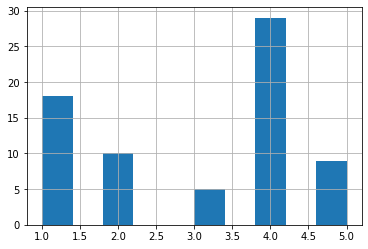

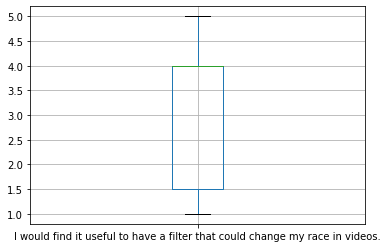

Low Education


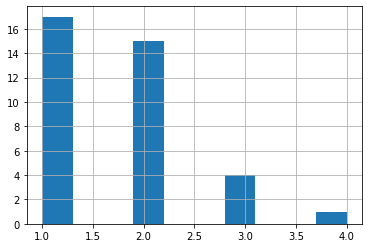

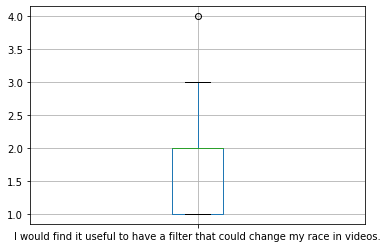

,count,mean,std,min,25%,50%,75%,max
What is your education level?,,,,,,,,
Bachelor's Degree,56.0,3.089286,1.378758,1.0,2.0,4.0,4.0,5.0
High School,12.0,1.666667,0.984732,1.0,1.0,1.0,2.0,4.0
Master's Degree,15.0,2.733333,1.709915,1.0,1.0,4.0,4.0,5.0
Some College,23.0,1.695652,0.702902,1.0,1.0,2.0,2.0,3.0
Trade School,2.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0


p-value =  7.432127296637163e-06
u-value=  -2.854235271692773
High Education:  [0.11594800731934285, 3.0140845070422535, 5.912221006765164]
Low Education:  [0.14886409640717901, 1.7027027027027026, 3.2565413089982265]
There is a Difference:  False


I would want a viewer to have the option to change my race in videos.
High Education


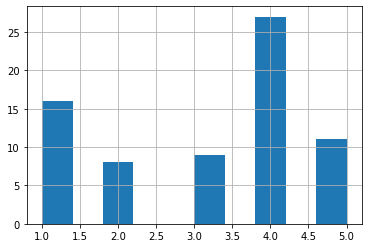

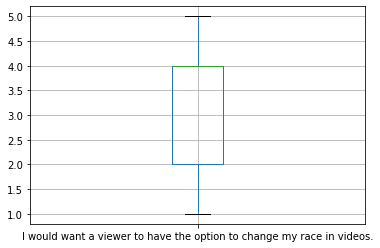

Low Education


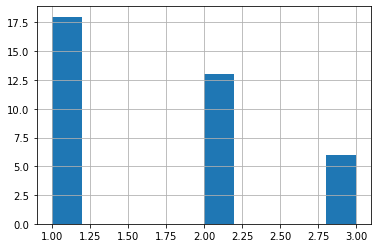

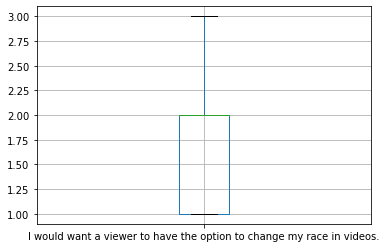

,count,mean,std,min,25%,50%,75%,max
What is your education level?,,,,,,,,
Bachelor's Degree,56.0,3.125000,1.349242,1.0,2.0,4.0,4.00,5.0
High School,12.0,1.750000,0.866025,1.0,1.0,1.5,2.25,3.0
Master's Degree,15.0,3.133333,1.726543,1.0,1.0,4.0,4.50,5.0
Some College,23.0,1.695652,0.702902,1.0,1.0,2.0,2.00,3.0
Trade School,2.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0


p-value =  4.283701569389806e-07
u-value=  -2.854235271692773
High Education:  [0.2796150763095411, 3.1267605633802815, 5.973906050451022]
Low Education:  [0.18094016922838674, 1.6756756756756757, 3.1704111821229644]
There is a Difference:  False


I would find it useful to have a filter that could change my gender in videos.
High Education


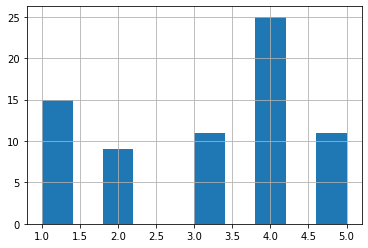

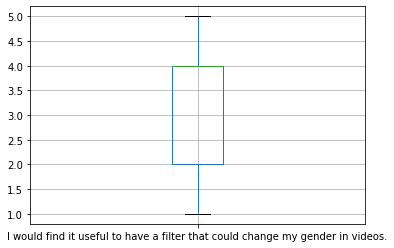

Low Education


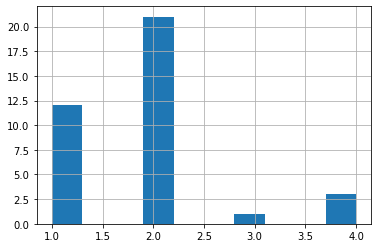

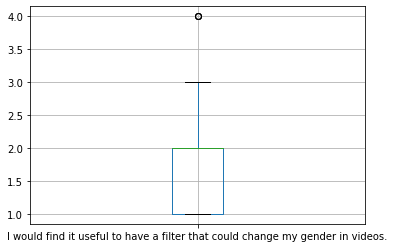

,count,mean,std,min,25%,50%,75%,max
What is your education level?,,,,,,,,
Bachelor's Degree,56.0,3.160714,1.385336,1.0,2.0,3.5,4.0,5.0
High School,12.0,1.833333,1.114641,1.0,1.0,1.5,2.0,4.0
Master's Degree,15.0,2.933333,1.486447,1.0,1.0,4.0,4.0,5.0
Some College,23.0,1.869565,0.694416,1.0,1.5,2.0,2.0,4.0
Trade School,2.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0


p-value =  9.509097002814272e-06
u-value=  -2.854235271692773
High Education:  [0.31371102772685644, 3.112676056338028, 5.911641084949199]
Low Education:  [0.22087499181129244, 1.864864864864865, 3.5088547379184374]
There is a Difference:  False


I would want a viewer to have the option to change my gender in videos.
High Education


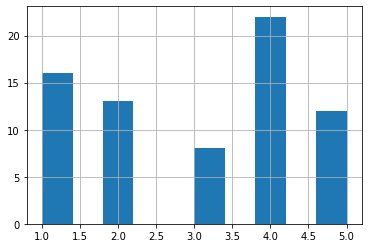

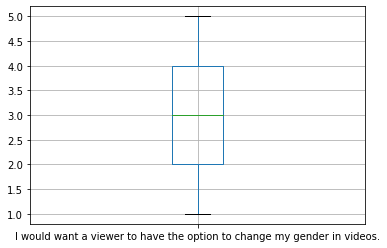

Low Education


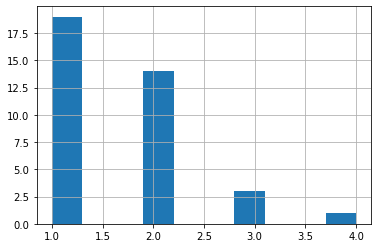

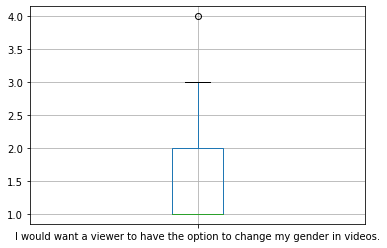

,count,mean,std,min,25%,50%,75%,max
What is your education level?,,,,,,,,
Bachelor's Degree,56.0,2.982143,1.381581,1.0,2.00,3.0,4.00,5.0
High School,12.0,1.500000,0.674200,1.0,1.00,1.0,2.00,3.0
Master's Degree,15.0,3.133333,1.726543,1.0,1.00,4.0,4.50,5.0
Some College,23.0,1.695652,0.822125,1.0,1.00,2.0,2.00,4.0
Trade School,2.0,1.500000,0.707107,1.0,1.25,1.5,1.75,2.0


p-value =  1.4958499812049331e-06
u-value=  -2.854235271692773
High Education:  [0.1159480073193433, 3.0140845070422535, 5.912221006765163]
Low Education:  [0.10494752996570456, 1.6216216216216217, 3.1382957132775386]
There is a Difference:  False




In [15]:
# Education Cell
# Compute the Mann-Whitney rank test on samples x and y
# scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)

g = df.groupby('What is your education level?')

df_lowedu = df[(df['What is your education level?'] == 'Trade School') |
             (df['What is your education level?'] == 'Some High School') | 
             (df['What is your education level?'] == 'High School') |
             (df['What is your education level?'] == 'Some College')].copy()

df_highedu = df[(df['What is your education level?'] == "Bachelor's Degree") | 
             (df['What is your education level?'] == "Master's Degree") |
             (df['What is your education level?'] == 'Ph.D. or higher')].copy()

for q in q_list:
    col_name = q
    print(col_name)
    print("High Education")
    df_highedu[col_name].hist()
    plt.show()
    df_highedu.boxplot(col_name)
    plt.show()
    print("Low Education")
    df_lowedu[col_name].hist()
    plt.show()
    df_lowedu.boxplot(col_name)
    plt.show()
    display(g[col_name].describe())
    #Statistic test
    u,p = mannwhitneyu(df_highedu[col_name], df_lowedu[col_name])
    print('p-value = ', p)
    print('u-value= ', t)
    mu1 = df_highedu[col_name].mean()
    std1 = df_highedu[col_name].std()
    mu2 = df_lowedu[col_name].mean()
    std2 = df_lowedu[col_name].std()
    print("High Education: ", compute_interval95(mu1, std1))
    print("Low Education: ", compute_interval95(mu2, std2))
    print("There is a Difference: ", is_difference(compute_interval95(mu1, std1), compute_interval95(mu2, std2)))
    print('\n========================================\n')

I would find it useful to have a filter that could change my race in videos.
PD agree


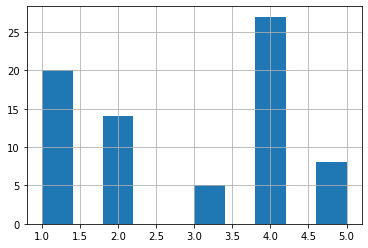

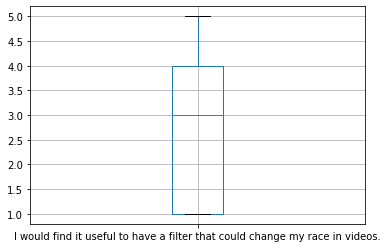

PD disagree


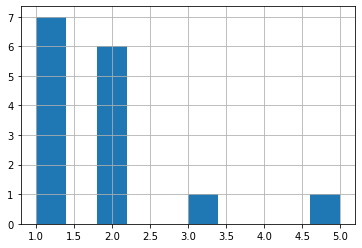

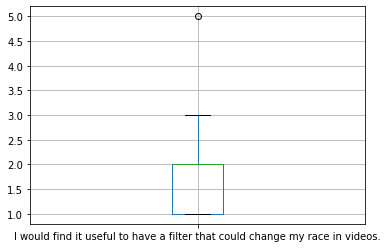

,count,mean,std,min,25%,50%,75%,max
The speaker should have the option to remove the tremors from the video.,,,,,,,,
1,3.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,12.0,2.000000,1.128152,1.0,1.0,2.0,2.0,5.0
3,19.0,2.052632,1.129094,1.0,1.0,2.0,3.0,4.0
4,44.0,2.840909,1.429639,1.0,1.0,3.5,4.0,5.0
5,30.0,2.866667,1.479360,1.0,2.0,2.5,4.0,5.0


p-value =  0.007088850968741378
u-value=  -2.854235271692773
PD agree:  [-0.028573161214000997, 2.8513513513513513, 5.731275863916704]
PD disagree:  [-0.36465107712866396, 1.8, 3.9646510771286643]
There is a Difference:  False


I would want a viewer to have the option to change my race in videos.
PD agree


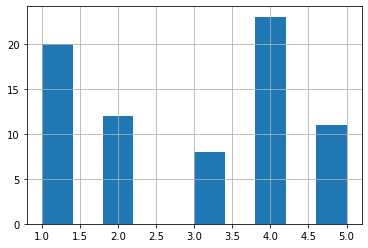

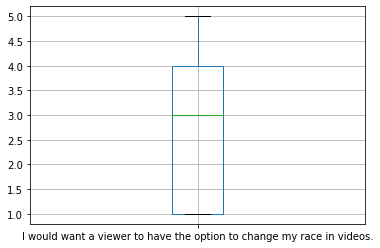

PD disagree


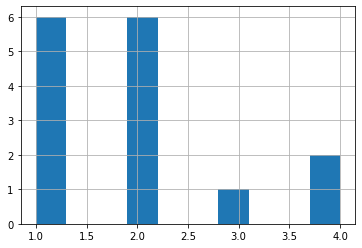

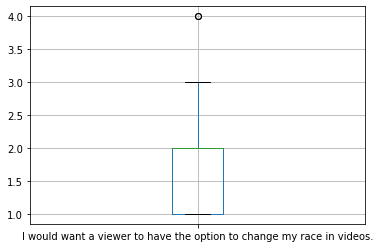

,count,mean,std,min,25%,50%,75%,max
The speaker should have the option to remove the tremors from the video.,,,,,,,,
1,3.0,1.333333,0.577350,1.0,1.00,1.0,1.50,2.0
2,12.0,2.083333,1.083625,1.0,1.00,2.0,2.25,4.0
3,19.0,2.105263,1.100239,1.0,1.00,2.0,3.00,4.0
4,44.0,2.886364,1.401260,1.0,1.00,3.5,4.00,5.0
5,30.0,2.933333,1.595972,1.0,1.25,3.0,4.75,5.0


p-value =  0.01212896985303197
u-value=  -2.854235271692773
PD agree:  [-0.040107437704028026, 2.9054054054054053, 5.850918248514839]
PD disagree:  [-0.13225778464395543, 1.9333333333333333, 3.9989244513106224]
There is a Difference:  False


I would find it useful to have a filter that could change my gender in videos.
PD agree


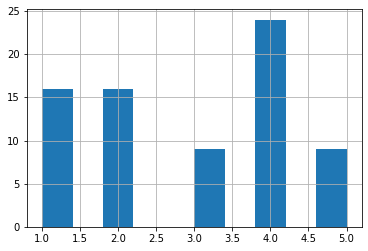

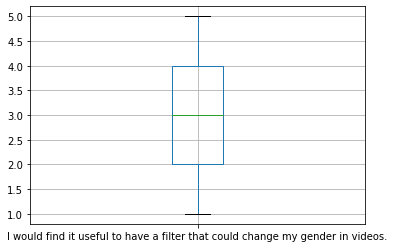

PD disagree


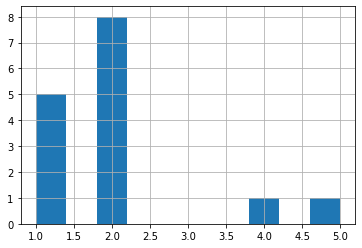

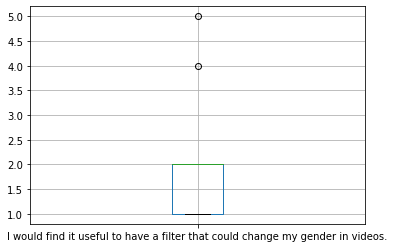

,count,mean,std,min,25%,50%,75%,max
The speaker should have the option to remove the tremors from the video.,,,,,,,,
1,3.0,1.333333,0.577350,1.0,1.00,1.0,1.5,2.0
2,12.0,2.166667,1.193416,1.0,1.75,2.0,2.0,5.0
3,19.0,2.315789,1.249561,1.0,1.00,2.0,3.0,5.0
4,44.0,2.909091,1.326267,1.0,2.00,3.0,4.0,5.0
5,30.0,2.933333,1.484014,1.0,2.00,2.5,4.0,5.0


p-value =  0.011986735499354806
u-value=  -2.854235271692773
PD agree:  [0.15403626626758893, 2.918918918918919, 5.683801571570249]
PD disagree:  [-0.2677868380553634, 2.0, 4.267786838055363]
There is a Difference:  False


I would want a viewer to have the option to change my gender in videos.
PD agree


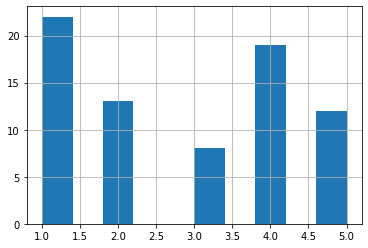

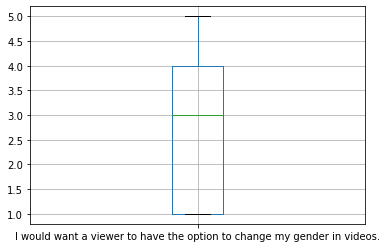

PD disagree


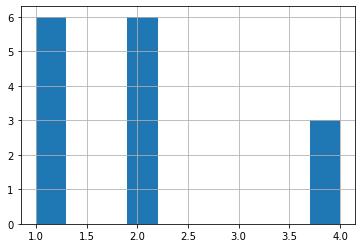

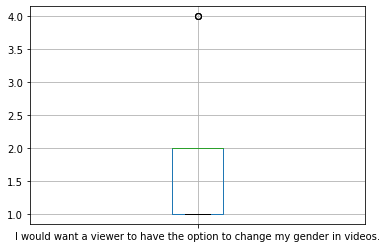

,count,mean,std,min,25%,50%,75%,max
The speaker should have the option to remove the tremors from the video.,,,,,,,,
1,3.0,1.000000,0.000000,1.0,1.00,1.0,1.0,1.0
2,12.0,2.250000,1.138180,1.0,1.75,2.0,2.5,4.0
3,19.0,1.894737,0.875261,1.0,1.00,2.0,2.0,4.0
4,44.0,2.840909,1.477635,1.0,1.00,3.0,4.0,5.0
5,30.0,2.766667,1.568732,1.0,1.00,2.5,4.0,5.0


p-value =  0.03532209101411419
u-value=  -2.854235271692773
PD agree:  [-0.19923038811855376, 2.810810810810811, 5.820852009740175]
PD disagree:  [-0.2677868380553634, 2.0, 4.267786838055363]
There is a Difference:  False


The speaker should have the option to remove the tremors from the video.
PD agree


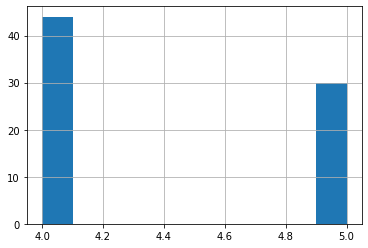

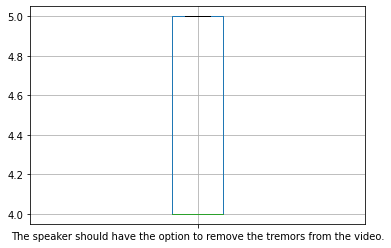

PD disagree


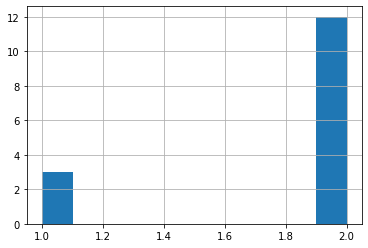

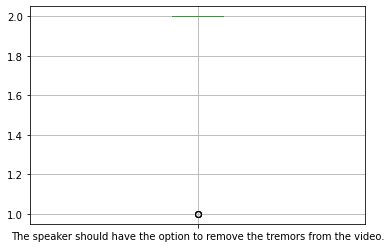

,count,mean,std,min,25%,50%,75%,max
The speaker should have the option to remove the tremors from the video.,,,,,,,,
1,3.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,12.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
3,19.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
4,44.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0
5,30.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0


p-value =  1.602244371402047e-11
u-value=  -2.854235271692773
PD agree:  [3.4167620056214787, 4.405405405405405, 5.394048805189332]
PD disagree:  [0.9719213287891749, 1.8, 2.628078671210825]
There is a Difference:  True




In [20]:
# split off agree vs disagree with PD filter 
# Compute the Mann-Whitney rank test on samples x and y
# scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)

g = df.groupby('The speaker should have the option to remove the tremors from the video.')

df_pd_agree = df[(df['The speaker should have the option to remove the tremors from the video.'] == 4) |
                (df['The speaker should have the option to remove the tremors from the video.'] == 5)].copy()
df_pd_disagree = df[(df['The speaker should have the option to remove the tremors from the video.'] == 1) |
                (df['The speaker should have the option to remove the tremors from the video.'] == 2)].copy()

for q in q_list:
    col_name = q
    print(col_name)
    print("PD agree")
    df_pd_agree[col_name].hist()
    plt.show()
    df_pd_agree.boxplot(col_name)
    plt.show()
    print("PD disagree")
    df_pd_disagree[col_name].hist()
    plt.show()
    df_pd_disagree.boxplot(col_name)
    plt.show()
    display(g[col_name].describe())
    #Statistic test
    u,p = mannwhitneyu(df_pd_agree[col_name], df_pd_disagree[col_name])
    print('p-value = ', p)
    print('u-value= ', t)
    mu1 = df_pd_agree[col_name].mean()
    std1 = df_pd_agree[col_name].std()
    mu2 = df_pd_disagree[col_name].mean()
    std2 = df_pd_disagree[col_name].std()
    print("PD agree: ", compute_interval95(mu1, std1))
    print("PD disagree: ", compute_interval95(mu2, std2))
    print("There is a Difference: ", is_difference(compute_interval95(mu1, std1), compute_interval95(mu2, std2)))
    print('\n========================================\n')